In [ ]:
#default_exp ml.loss

# Loss functions

In [ ]:
#hide
from fastcore.test import *
from nbdev.showdoc import *

### Binary focal loss

Focal Loss for Dense Object Detection

<sup>
T.-Y. Lin, P. Goyal, R. Girshick, K. He, and P. Dollar, “Focal loss for dense object detection,” in Proceedings of the IEEE International Conference on Computer Vision (ICCV), Oct 2017.
</sup>

$$
\begin{equation*}
    p_T = 
    \begin{cases}
        p &\quad \text{if y = 1} \\
        1 - p &\quad \text{otherwise}
    \end{cases}
\end{equation*}
$$
$$
\begin{equation}
    \text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma}\log{p_t} 
\end{equation}
$$

<sup>
Credit for implementation:
https://www.kaggle.com/crissallan/pytorchlightning-efficientnet-focalloss-training
</sup>

In [ ]:
#export
import torch
from torch import nn
from fastcore.basics import ifnone

class BinaryFocalLoss(nn.Module):
    """
    The focal loss for fighting against class-imbalance
    """
    def __init__(self, alpha=1, gamma=2, weight=None, reduction=torch.mean, thresh=0.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = None if weight is None else torch.tensor([weight], dtype=torch.float, requires_grad=False, device='cuda')
        self.reduction = reduction
        self.thresh = 0.5
        self.eps = 1e-12 # prevent training from Nan-loss error

    def forward(self, logits, targets):
        """
        logits & target should be tensors with shape [batch_size, num_classes]
        """
        probs = torch.sigmoid(logits)
        log_pt = targets * torch.log(probs + self.eps) + (1.0 - targets) * torch.log(1.0 - probs + self.eps)
        focal_loss = -self.alpha * ((1 - torch.exp(log_pt)) ** self.gamma) * log_pt
        if self.weight is not None:
            focal_loss = focal_loss * self.weight
        
        reduction = ifnone(self.reduction, lambda x:x)
        return reduction(focal_loss)
    
    def decodes(self, x):    
        return x > self.thresh

    def activation(self, x): 
        return torch.sigmoid(x)

In [ ]:
targets = torch.tensor([
    [1,0,0,1,0],
    [0,0,1,0,1],
    [0,1,0,1,0],
    [0,0,0,1,1],
], dtype=float)

logits = torch.tensor([
    [1,-1,-1,1,-1],
    [-1,-1,1,-1,1],
    [-1,1,-1,1,-1],
    [-1,-1,-1,1,1],
],dtype=float)*1e6

# verify BCE results in zero loss with these inputs
bce = nn.BCEWithLogitsLoss()
test_close(bce(logits, targets).numpy(), 0.0)

# test binary focal loss
fl = BinaryFocalLoss()
activations = fl.activation(logits)

test_close(fl(logits, targets).numpy(), 0.0)
test_close(activations, targets)
test_close(fl.decodes(activations).float(), targets)

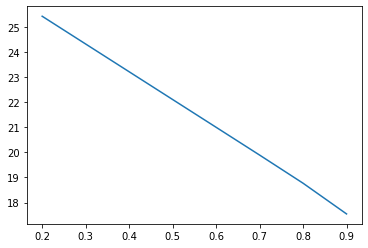

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

logits = torch.rand(targets.shape) * 1e6
ps = np.arange(0.2, 1.0, 0.1)
losses = np.array([fl(logits, targets*p).numpy() for p in ps])

plt.figure()
plt.plot(ps, losses)